# Cyclistic Bike-Share Analysis: Google Data Analytics Capstone

**Business Task:**  
Analyze how annual members and casual riders use Cyclistic bikes differently, and provide recommendations to help convert casual riders into annual members.

In [ ]:
# Install packages if not already installed
# install.packages("tidyverse")
# install.packages("lubridate")
# install.packages("janitor")

library(tidyverse)
library(lubridate)
library(janitor)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘snakecase’



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Data Source

We used Cyclistic trip data from:
- Q1 2019: `Divvy_Trips_2019_Q1.csv`
- Q1 2020: `Divvy_Trips_2020_Q1.csv`


In [ ]:
divvy_2019_q1 <- read_csv("Divvy_Trips_2019_Q1.csv")
divvy_2020_q1 <- read_csv("Divvy_Trips_2020_Q1.csv")


Rows: 298576 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): start_time, end_time, from_station_name, to_station_name, usertype,...
dbl (5): trip_id, bikeid, from_station_id, to_station_id, birthyear
num (1): tripduration

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 300355 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): ride_id, rideable_type, started_at, ended_at, start_station_name, e...
dbl (6): start_station_id, end_station_id, start_lat, start_lng, end_lat, en...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Data Cleaning

We clean and transform both datasets to a consistent format and add new variables.


In [ ]:
divvy_2019_q1_clean <- divvy_2019_q1 %>%
  rename(
    ride_id = trip_id,
    rideable_type = bikeid,
    started_at = start_time,
    ended_at = end_time,
    start_station_name = from_station_name,
    end_station_name = to_station_name,
    user_type = usertype
  ) %>%
  mutate(
    ride_id = as.character(ride_id),
    rideable_type = "classic_bike",  # overwrite to match 2020 format
    started_at = ymd_hms(started_at),
    ended_at = ymd_hms(ended_at),
    ride_length = as.numeric(difftime(ended_at, started_at, units = "mins")),
    member_casual = if_else(user_type == "Subscriber", "member", "casual")
  ) %>%
  select(ride_id, rideable_type, started_at, ended_at,
         start_station_name, end_station_name, member_casual, ride_length)


In [ ]:
divvy_2020_q1_clean <- divvy_2020_q1 %>%
  mutate(
    started_at = ymd_hms(started_at),
    ended_at = ymd_hms(ended_at),
    ride_length = as.numeric(difftime(ended_at, started_at, units = "mins"))
  ) %>%
  select(ride_id, rideable_type, started_at, ended_at,
         start_station_name, end_station_name, member_casual, ride_length)


## Combine Data


In [ ]:
all_trips <- bind_rows(divvy_2019_q1_clean, divvy_2020_q1_clean)


## Data Summary: Ride Length Statistics by User Type


In [ ]:
ride_length_summary <- all_trips %>%
  group_by(member_casual) %>%
  summarise(
    avg_ride_length = mean(ride_length, na.rm = TRUE),
    median_ride_length = median(ride_length, na.rm = TRUE),
    max_ride_length = max(ride_length, na.rm = TRUE),
    min_ride_length = min(ride_length, na.rm = TRUE)
  )

ride_length_summary


member_casual,avg_ride_length,median_ride_length,max_ride_length,min_ride_length
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
casual,103.92925,20.600000,177200.4,-1.55000000
member,13.09484,8.283333,101607.1,0.01666667


## Visualization: Ride Length Distribution (Filtered)


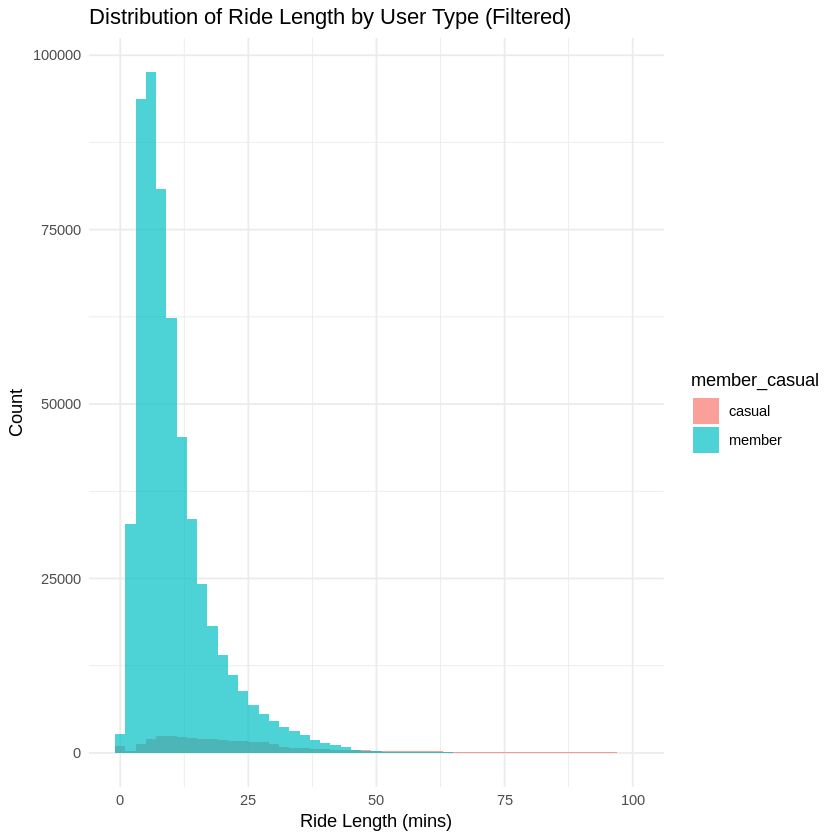

In [ ]:
filtered_trips <- all_trips %>%
  filter(ride_length > 0, ride_length <= 100)

ggplot(filtered_trips, aes(x = ride_length, fill = member_casual)) +
  geom_histogram(binwidth = 2, alpha = 0.7, position = "identity") +
  labs(title = "Distribution of Ride Length by User Type (Filtered)",
       x = "Ride Length (mins)", y = "Count") +
  theme_minimal()


## Weekly Ride Patterns by Member Type


`summarise()` has grouped output by 'day_of_week'. You can override using the
`.groups` argument.


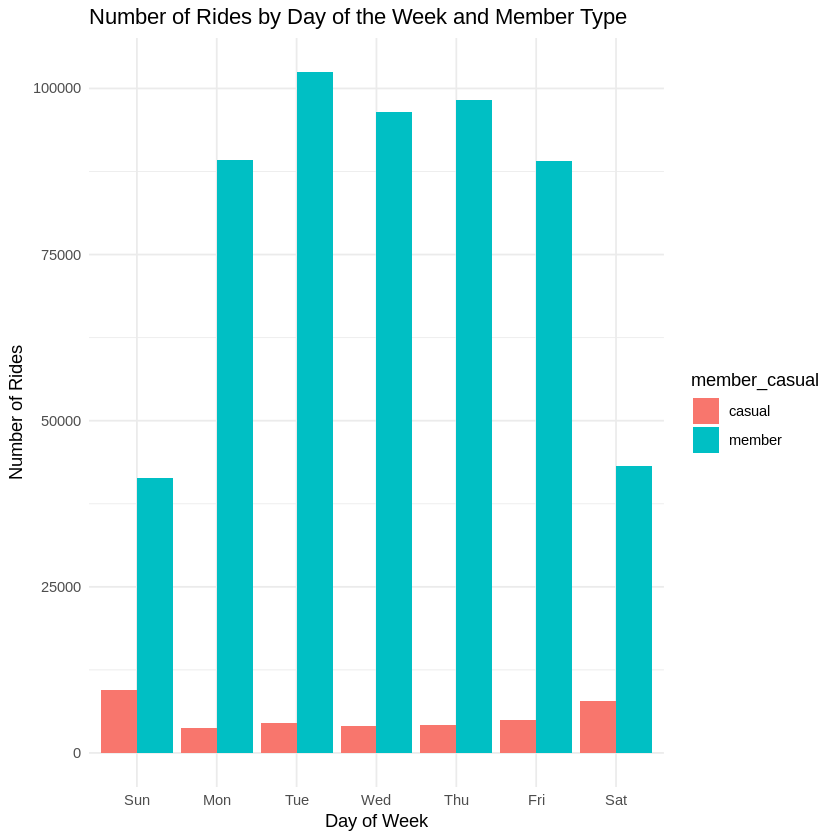

In [ ]:
all_trips <- all_trips %>%
  mutate(day_of_week = wday(started_at, label = TRUE))

weekly_rides_by_type <- all_trips %>%
  group_by(day_of_week, member_casual) %>%
  summarise(ride_count = n())

ggplot(weekly_rides_by_type, aes(x = day_of_week, y = ride_count, fill = member_casual)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Number of Rides by Day of the Week and Member Type",
       x = "Day of Week", y = "Number of Rides") +
  theme_minimal()


## Ride Length Comparison: Weekday vs Weekend (Casual Riders)


In [ ]:
all_trips <- all_trips %>%
  mutate(weekend = if_else(day_of_week %in% c("Sat", "Sun"), "Weekend", "Weekday"))

casual_weekend_ride_length <- all_trips %>%
  filter(member_casual == "casual") %>%
  group_by(weekend) %>%
  summarise(avg_ride_length = mean(ride_length, na.rm = TRUE))

casual_weekend_ride_length


weekend,avg_ride_length
<chr>,<dbl>
Weekday,107.16886
Weekend,99.95385


## Insights Summary

- Casual riders take longer rides on average than members.
- Members ride more frequently during weekdays (possibly for commuting).
- Casual riders ride more during weekends, indicating leisure usage.

These patterns highlight distinct usage behaviors, useful for targeted marketing.


## Recommendations

1. **Weekend Membership Promotions**  
   Offer targeted discounts for casual riders who frequently ride on weekends.

2. **Leisure-Focused Digital Ads**  
   Promote annual plans with messaging around flexibility and long leisure rides.

3. **Personalized Nudges via App**  
   Suggest membership based on frequent usage or long ride patterns.

These strategies align with the goal of converting casual users into loyal annual members.
